In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms as transforms
from skimage.util import montage
from scipy.stats import pearsonr
import os
import cv2
import random
import matplotlib.pyplot as plt

import torch.optim as optim
from PIL import Image
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, \
confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import glob
from tqdm import trange
import shutil
import numpy as np
import scipy as sp
import seaborn as sns
import pydicom as dicom
import scipy.io as sio 

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
from skimage import measure

plt.style.use('bmh')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [29]:
# path to saving all figures
fig_path = '/Volumes/GoogleDrive/My Drive/Pauly Lab/HUNet/Results/dense3Dconv/figures/'

# Data Preprocessing

## FragData
FragData contains many useful information regarding the fragments including the measured sound velocity per fragment. For each fragment, speed of sound is measured three times. In the following plot we show all three values for each fragment. In most cases these values are close to one another, but in some cases they differ by a wide margin. ```sos_raw``` contains all of these measurements per fragment.

If running the code on your local machine, it is faster to simply load the matlab file using the following:
```python
FragData = sio.loadmat('path to FragData.mat', squeezeme=True)
```

But if you are planning on publicly hosting your data say on Google Drive and want others be able to download it directly into the notebook, you need to run the following:
```python
!gdown https://drive.google.com/public_link_to_FragData.mat
```

In [30]:
data_raw = sio.loadmat('/Volumes/GoogleDrive/My Drive/Courses/CS 230/FragData/FragData.mat', squeeze_me=True)

In [31]:
# download the fragment data
# this will take about 1 minute 
#!gdown https://drive.google.com/uc?id=1rqppEEc0UbD04tyxYzWT17MTS8IhZBC_

In [32]:
# define a data class that extracts all the necessary attributes 
class FragDataClass:
  def __init__(self, data_raw):
    self.sos_raw = np.zeros((100, 3))
    self.thickness = np.zeros(100)
    self.density = np.zeros(100)

    for i, fragment in enumerate(data_raw['FragData']['Velocity']):
      self.sos_raw[i, :] = np.reshape(data_raw['FragData']['Velocity'][i]
                                      ['measuredVelocity'], (-1,))[0]
      self.thickness[i] = data_raw['FragData']['thickness'][i]
      self.density[i] = data_raw['FragData']['density'][i]

  # since in some measurements there is an outlier, I will remove
  # the velocity measurements that are more than 1 std away from teh mean
  def mean_velocity(self):
    self.sos_mean = np.zeros(100)
    for i, temp_vel in enumerate(self.sos_raw):
      std = np.std(temp_vel)
      temp_vel_centered = temp_vel - np.mean(temp_vel)
      idx = []
      for j, k in enumerate(temp_vel_centered):
        if k >= std:
          idx.append(j)
      temp_vel = np.delete(temp_vel, idx)
      self.sos_mean[i] = np.mean(temp_vel)
    
    return self.sos_mean 

In [33]:
FragData = FragDataClass(data_raw)

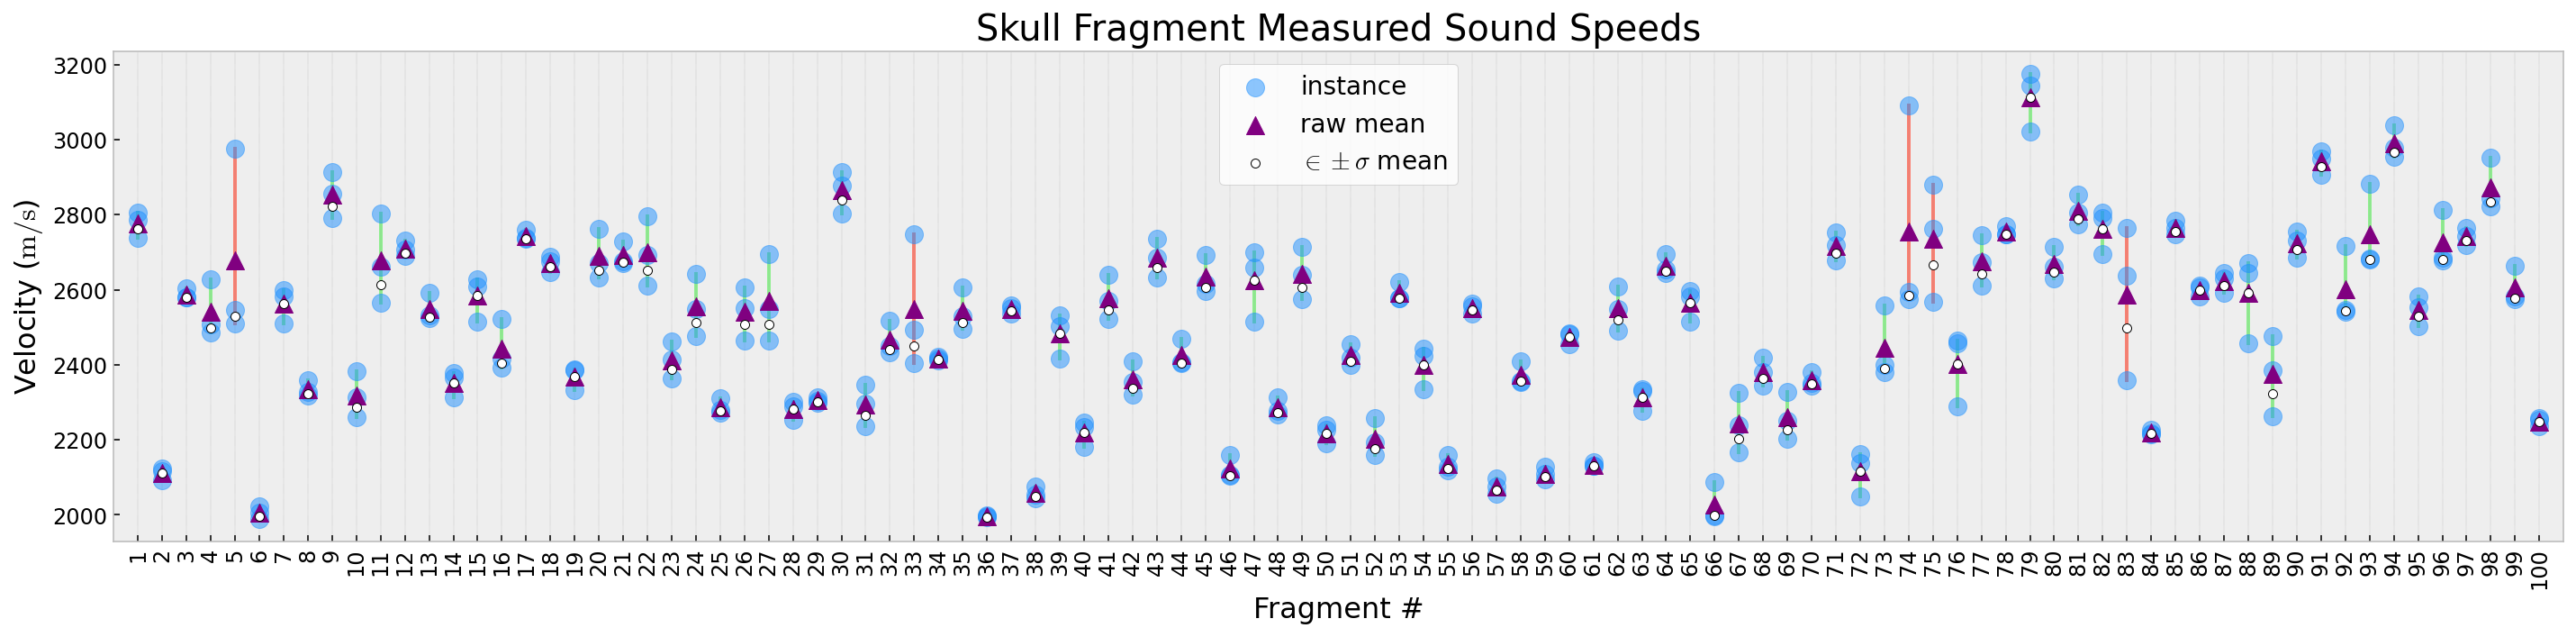

In [34]:
frag_idx = np.arange(1, 101)
plt.figure(figsize=(20, 5))
# flag those fragments for which the three measured sos's differ by more than 
# 300 m/s.
for idx in frag_idx:
  # if delta < 300 m/s, a vertical green line connects the three measurements
    if  max(FragData.sos_raw[idx-1]) - min(FragData.sos_raw[idx-1]) < 300:
        plt.plot([idx, idx], [min(FragData.sos_raw[idx-1]), 
                              max(FragData.sos_raw[idx-1])], 
                 color='lightgreen', lw=2)
  # if delta > 300 m/s, a vertical red line connects the three measurements      
    else:
        plt.plot([idx, idx], [min(FragData.sos_raw[idx-1]), 
                              max(FragData.sos_raw[idx-1])], 
                 color='salmon', lw=2)

    plt.axvline(x=idx, lw=0.2, c='gray', ls=':')
    plt.scatter(idx, FragData.sos_raw[idx-1][0], color='dodgerblue', zorder=10, 
                label='instance' if idx == 1 else '', s=100, alpha=0.5)
    plt.scatter(idx, FragData.sos_raw[idx-1][1], color='dodgerblue', zorder=10,
               s=100, alpha=0.5)
    plt.scatter(idx, FragData.sos_raw[idx-1][2], color='dodgerblue', zorder=10,
               s=100, alpha=0.5)
    plt.scatter(idx, np.mean(np.mean(FragData.sos_raw[idx-1])), color='purple', 
                zorder=20, label='raw mean' if idx == 1 else '', marker='^', 
                s=100)
    plt.scatter(idx, FragData.mean_velocity()[idx-1], color='white', 
                edgecolors='k', zorder=20, label='$\in\pm\sigma$ mean' 
                if idx == 1 else '', 
                marker='.', s=100)
plt.grid(False)
plt.title('Skull Fragment Measured Sound Speeds', fontsize=20)
plt.ylabel('Velocity ($\mathrm{m/s}$)', fontsize=16)
plt.xlabel('Fragment #', fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(np.arange(1, 101, 1), rotation='vertical', fontsize=12)
plt.xlim(0, 101)
plt.legend(facecolor='white', fontsize=14)
plt.tight_layout()
#plt.savefig(fig_path + 'skull_fragment_three_velocities.png', dpi=600)
plt.show()

## Target data
Since this is a regression problem, the labels/targets will be mean speed of sound across the skull fragment. The speed of sound for each fragment is stored in ```sos_mean```. 

```sos_mean``` is a 100-element long list of mean sound speeds for the 100 skull fragments.

In [35]:
# mean SOS for each fragment
sos_mean = FragData.mean_velocity()
frag_thickness = FragData.thickness
frag_density = FragData.density


In [36]:
# # run this cell only once
# np.save('/Volumes/GoogleDrive/My Drive/Pauly Lab/HUnet/SkullData/sos_mean.npy', sos_mean)

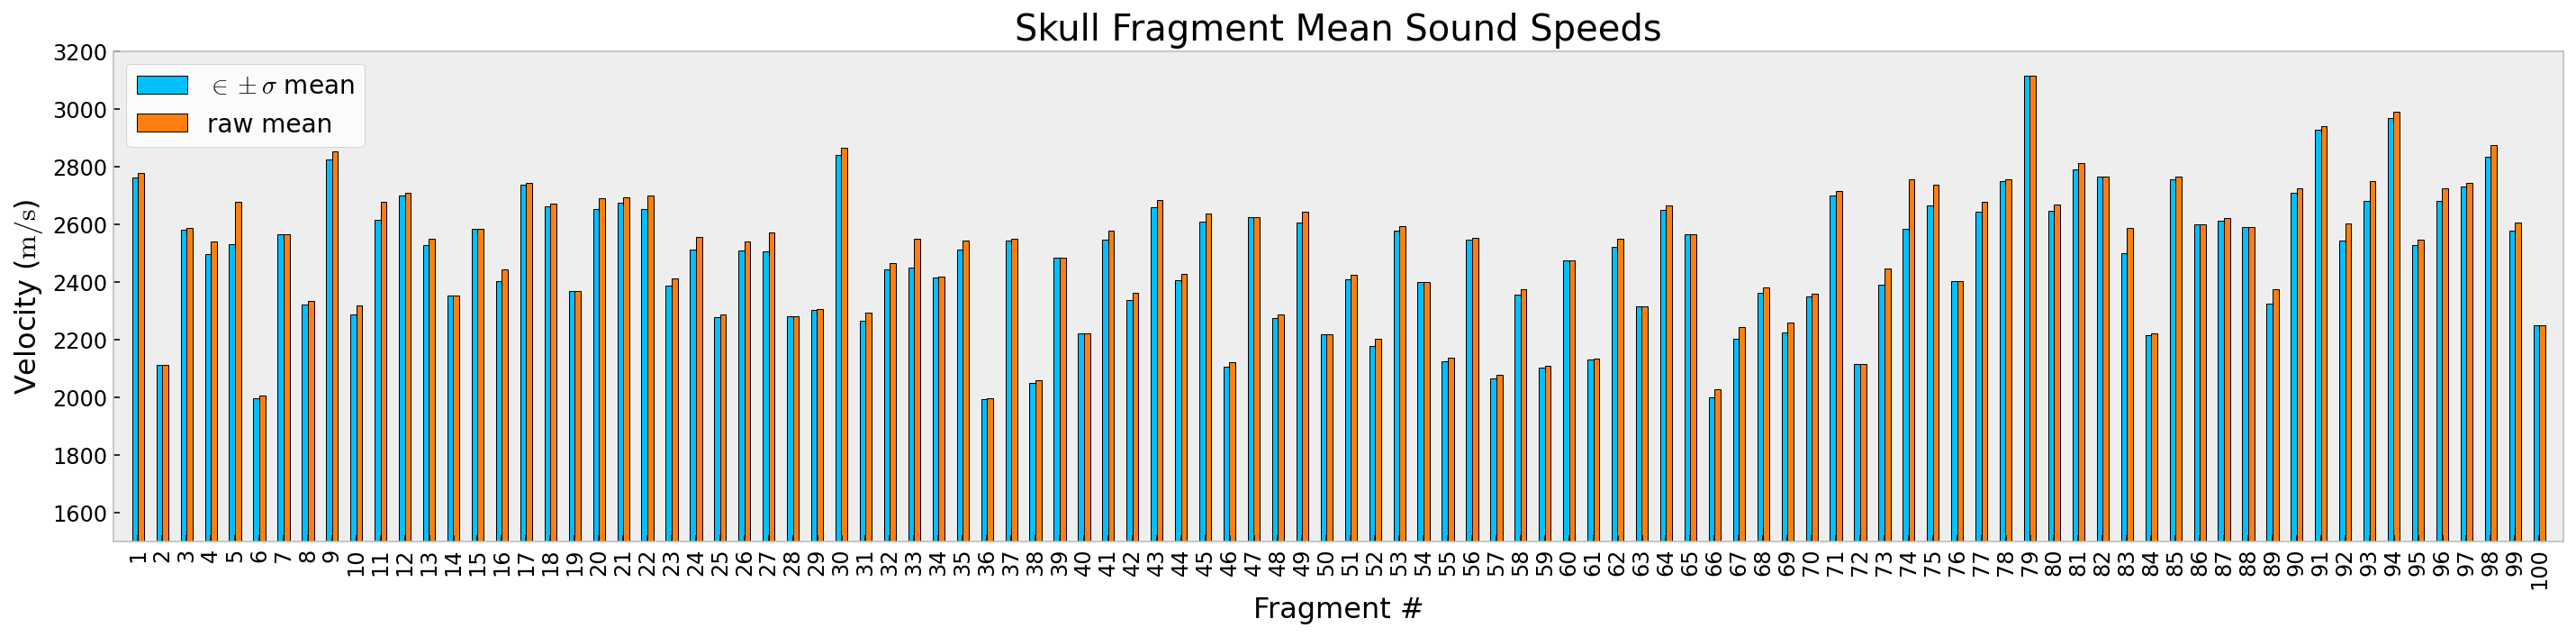

In [37]:
plt.figure(figsize=(20, 5))
plt.bar(frag_idx - 0.12, sos_mean, color='deepskyblue', width=0.25, 
        label='$\in\pm\sigma$ mean', edgecolor='k')
plt.bar(frag_idx + 0.12, np.mean(FragData.sos_raw, axis=1), color='tab:orange', 
        width=0.25, label='raw mean', edgecolor='k')
plt.grid(False)
plt.title('Skull Fragment Mean Sound Speeds', fontsize=20)
plt.ylabel('Velocity ($\mathrm{m/s}$)', fontsize=16)
plt.xlabel('Fragment #', fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(np.arange(1, 101, 1), rotation='vertical', fontsize=12)
plt.xlim(0, 101)
plt.ylim(1500, 3200)
plt.xticks(np.arange(1, 101, 1), rotation='vertical', fontsize=12)
plt.legend(facecolor='white', fontsize=14)

plt.tight_layout()
#plt.savefig(fig_path + 'skull_fragment_mean_velocities.png', dpi=600)
plt.show()

## Fragment Thickness and Density 
Another important point to take into consideration is the variation in the skull fragment thickness. Since different fragments have different thicknesses, the difference in their sound speed is not solely due to their density or pore structures. In other words, thickness is a confounding factor here. It is a reasonable expectation that having 3D convolution filters that scan across the depth of every skull, where we do not truncate the fragments to equal size depths, will be able to account for this. 

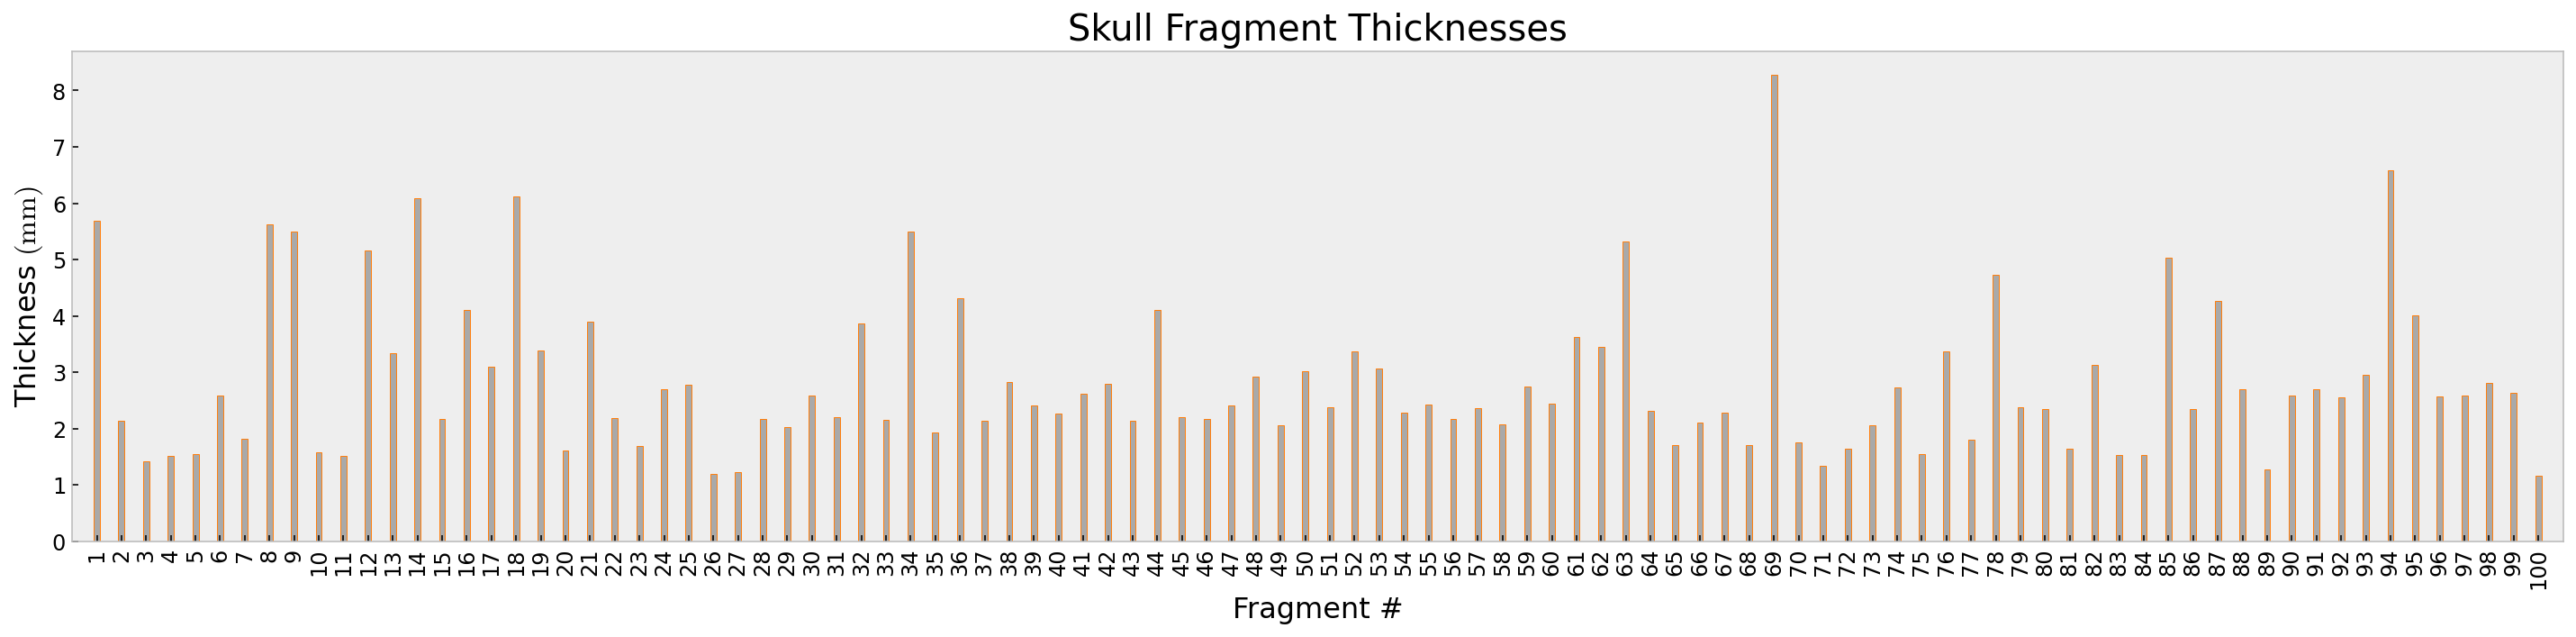

In [38]:
plt.figure(figsize=(20, 5))
plt.bar(frag_idx, frag_thickness*1000, color='darkgrey', 
        width=0.25, edgecolor='tab:orange')
plt.grid(False)
plt.title('Skull Fragment Thicknesses', fontsize=20)
plt.ylabel(r'Thickness $(\mathrm{mm})$', fontsize=16)
plt.xlabel('Fragment #', fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(np.arange(1, 101, 1), rotation='vertical', fontsize=12)
plt.xlim(0, 101)
plt.tight_layout()
#plt.savefig(fig_path + 'skull_fragment_thickness.png', dpi=600)
plt.show()

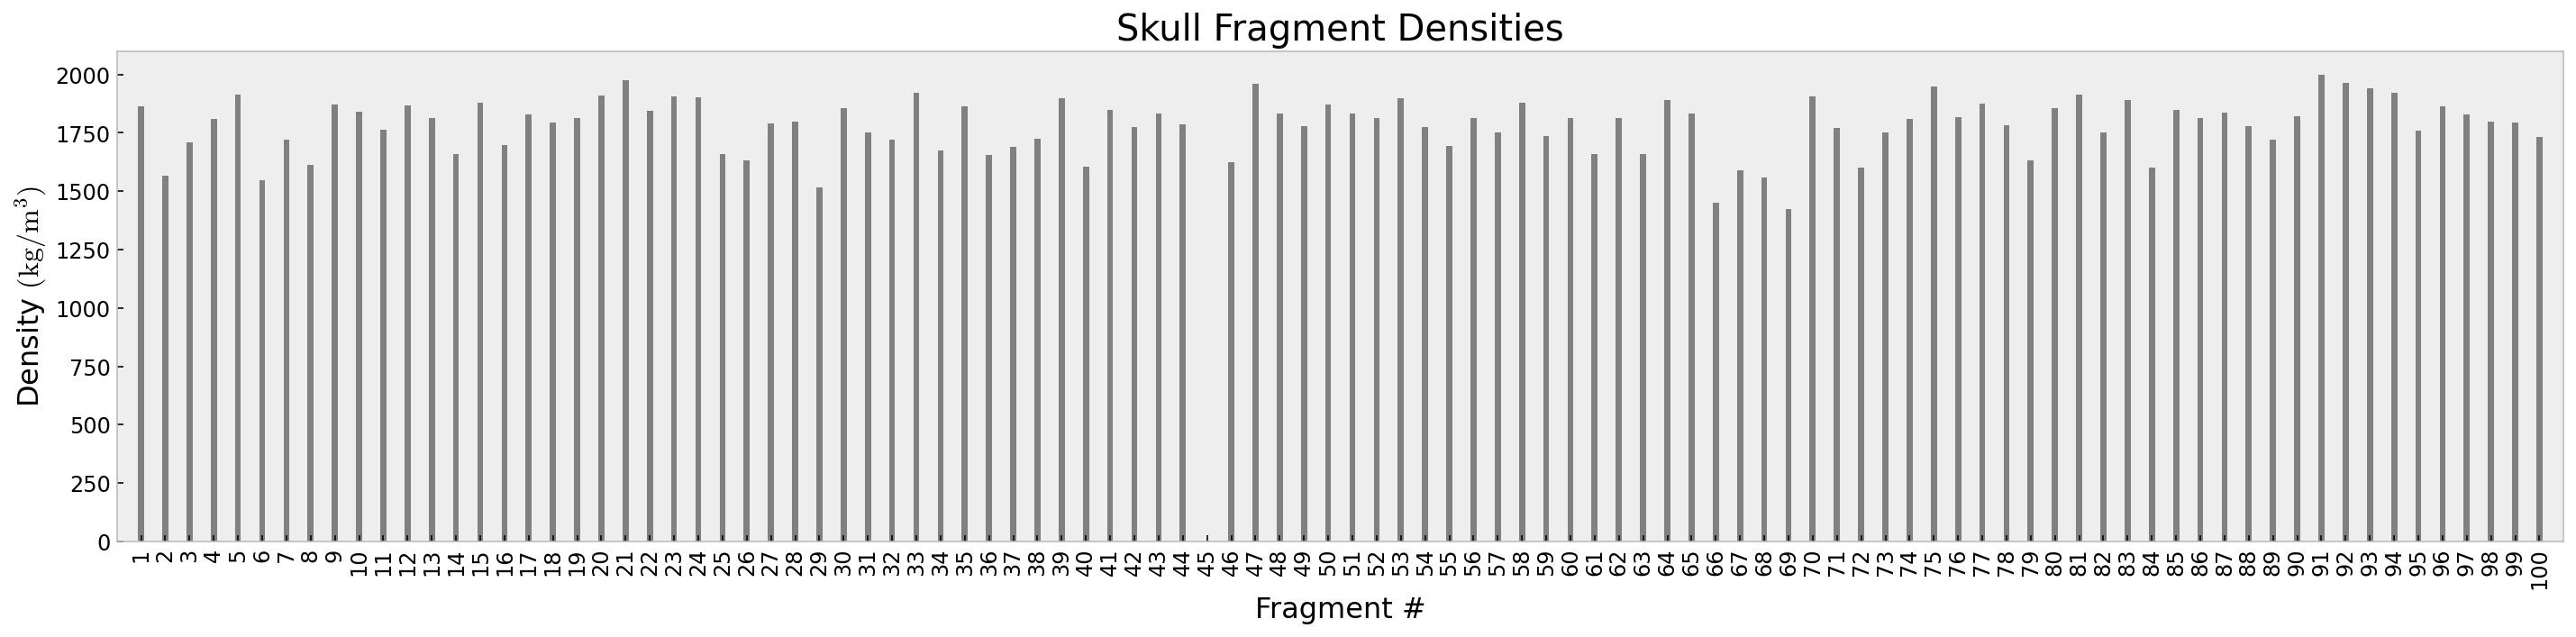

In [ ]:
plt.figure(figsize=(20, 5))
plt.bar(frag_idx, frag_density, color='gray', width=0.25)
plt.grid(False)
plt.title('Skull Fragment Densities', fontsize=20)
plt.ylabel('Density $(\mathrm{kg/m^3})$', fontsize=16)
plt.xlabel('Fragment #', fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(np.arange(1, 101, 1), rotation='vertical', fontsize=12)
plt.xlim(0, 101)
plt.tight_layout()
#plt.savefig(fig_path + 'skull_fragment_density.png', dpi=600)
plt.show()

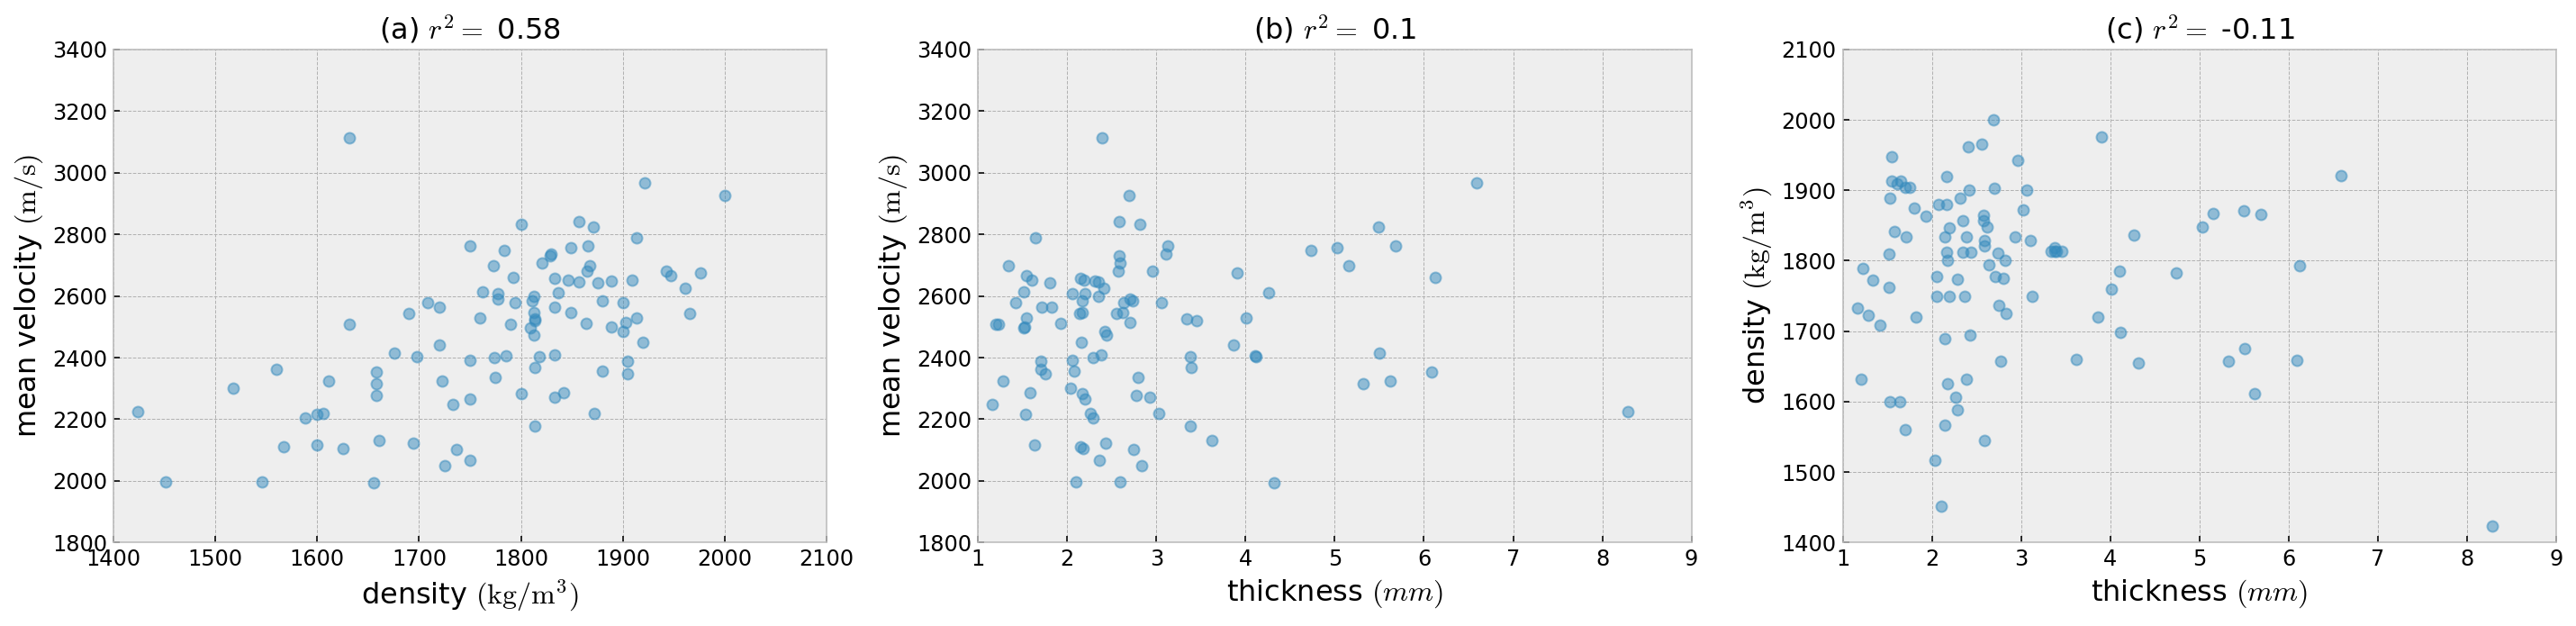

In [40]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
title = pearsonr(np.delete(frag_density, 44), np.delete(sos_mean, 44))[0]
plt.title('(a) $r^2=$ ' + str(np.round(title, 2)), fontsize=16)
plt.plot(frag_density, sos_mean, '.', markersize=12, alpha=0.5)
plt.xlabel('density $(\mathrm{kg/m^3})$', fontsize=16)
plt.ylabel(r'mean velocity $(\mathrm{m/s})$', fontsize=16)
plt.xlim(1400, 2100)
plt.ylim(1800, 3400)
plt.tick_params(axis='both', labelsize=12)

plt.subplot(1, 3, 2)
title = pearsonr(np.delete(frag_thickness, 44), np.delete(sos_mean, 44))[0]
plt.title('(b) $r^2=$ ' + str(np.round(title, 2)), fontsize=16)
plt.plot(frag_thickness * 1e3, sos_mean, '.', markersize=12, alpha=0.5)
plt.xlabel('thickness $(mm)$', fontsize=16)
plt.ylabel(r'mean velocity $(\mathrm{m/s})$', fontsize=16)
plt.xlim(1, 9)
plt.ylim(1800, 3400)
plt.tick_params(axis='both', labelsize=12)

plt.subplot(1, 3, 3)
title = pearsonr(np.delete(frag_density, 44), np.delete(frag_thickness, 44))[0]
plt.title('(c) $r^2=$ ' + str(np.round(title, 2)), fontsize=16)
plt.plot(frag_thickness * 1e3, frag_density, '.', markersize=12, alpha=0.5)
plt.xlabel('thickness $(mm)$', fontsize=16)
plt.ylabel(r'density $(\mathrm{kg/m^3})$', fontsize=16)
plt.xlim(1, 9)
plt.ylim(1400, 2100)
plt.tick_params(axis='both', labelsize=12)

plt.tight_layout()
#plt.savefig(fig_path + 'data_correlations.png', dpi=600)
plt.show()

In [43]:
data_vector = np.vstack((np.delete(frag_density, 44),  
                         np.delete(frag_thickness, 44), 
                         np.delete(sos_mean, 44))).T

In [44]:
mean = np.mean(data_vector, axis=0)
std = np.std(data_vector, axis=0)
data_vector = (data_vector - mean) / std
cov_matrix = 1 / 98 * data_vector.T @ data_vector

In [45]:
eig_val, eig_vec = np.linalg.eig(cov_matrix)

In [46]:
pc_1 = eig_vec[:, 1]
pc_2 = eig_vec[:, 2]

projection_1 = pc_1 @ data_vector.T
projection_2 = pc_2 @ data_vector.T
explained_variance = (eig_val[1] + eig_val[2]) / sum(eig_val)

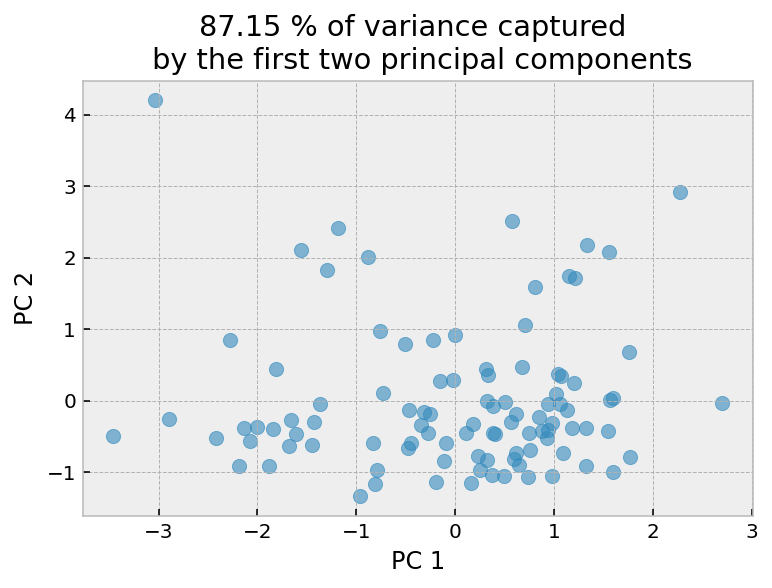

In [47]:
plt.title(str(np.round(explained_variance * 100, 2)) + ' % of variance captured\
 \n by the first two principal components')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.scatter(projection_1, projection_2, alpha=0.6, s=50)

Despite the fact that 87% of the varaince is captured by the first two principal components of the data covariance matrix, the spread is still not that much and data appear to be aggregating almost randomly. This suggests that linear regression models may have a difficult time extracting meaningful discriminatory insight from the data for accurate input-output mapping. 

## Manual Data Cleanup
There are three things we need to do in order to clean up the data before feeding it to our neural network. 

1. Dimension: 

  These fragments have varying thicknesses and so each scan has a different dimension. The variation is mostly in depth and not in the coronal plane. I decided to keep the depths varying so to reduce computation time, instead of having to zero pad all other fragments to the level of the thickest fragment. 

  One manual cleanup I have done is that I have removed emty scans in the beginning so that with the very first slice, skull begins. I have also cropped the scans in the coronal plane so to cut out the circular shape of the gragment as much as possible, making it easier for the neural network to focus on the internal pore structure. Every input has a dimension of $Z\times 312\times 312$, where Z varies depending on the fragment. 

2. Background: 

  There is some sort of a halo in these images that I suppose is due to the rubber bands used to affix the fragments. In order to make sure the network does not fit that halo, we need to remove it. Since we know that bone HU is greater than 1500, I set any voxels that have HUs below 1500 to 0.

3. Normalization:

  Both the acoustic velocity as well as the HUs need to be either standardized or normalized. Since these properties only take on positive values, I have normalized them. Obviously there should also be a reverse function that maps the output velocity to absolute velocity. These are defined further below. 



First we will define some helper functions that help us retreive the CT scans and reshape them all into the desired dimension as explained in part 1. 

### Helper Functions 
*to load the skull fragments, append the slices per fragment, and adjust the dimension.*


Each of the 100 fragments has its own file and there are varying number of DICOM scans per skull fragment. We need to define some helper functions that will collect and stack these DICOM slices so that each fragment is a 3D CT image (volume image) in DICOM format.

In [48]:
CT_path = '/Volumes/GoogleDrive/My Drive/Pauly Lab/HUnet/SkullData/microCT'

In [49]:
def load_scan(frag_path):
    ''' Load the slices per fragment
    
    Input parameter
    ----------------
    frag_path: path to individual skull fragments
    
    Output parameter
    ----------------
    slices: CT slices in DICOM format
    '''
    slices = [dicom.read_file(frag_path + '/' + s) for s in 
              os.listdir(frag_path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
        
    return(slices)

In [50]:
def get_hu(slices):
    ''' get the pixel values for each slice, stack them in order,
    and then convert to Hounsfield Units.  
    
    Input parameter
    ----------------
    slices: the CT slices we get from load_scan function
    
    Output parameter
    ----------------
    image_HU: the 3D volume image in HU units [numpy array]
    '''
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int64)
    
    # convert from pixels to HU
    intercept = slices[0].RescaleIntercept
    slope = slices[0].RescaleSlope
    
    image_HU = slope * image + np.int16(intercept)
    image_HU = np.asarray(image_HU, dtype=np.int16)
    
    # return the image in HU's 
    return(image_HU)

In [51]:
def reshape(img, dim):
    ''' Reshape the imaged into similar dimensions
    
    Input parameters
    -----------------
    img: CT volume image in HU [numpy array]
    dim: array specifying the target dimension [depth, height, width]
    
    Output parameters
    -----------------
    image: image of the size dim [numpy array]
    '''
 
    #D_curr, H_curr, W_curr = img.shape    # current depth, height, and width 
    H_curr, W_curr = img.shape[1:]         # current depth, height, and width 

    Hc, Wc = int(H_curr / 2), int(W_curr / 2) # center height and width 
    h, w = int(dim[1] / 2), int(dim[2] / 2)   # offset to set target height/width 
    image_cropped = np.stack([img[j, Hc - h:Hc + h, Wc - w:Wc + w] 
                              for j in range(len(img))])
    
    # artificially augment the depth to ensure equal shape for all fragments. 
    # copy the last layer n times and append to the end:
    #n = dim[0] - D_curr  # necessayr augmented layers to reach the desired depth
    #last_layer = np.zeros((1, dim[1], dim[2]))
    #aug_slice = np.repeat(last_layer, n, axis=0)

    #image_cropped = np.concatenate((image_cropped, aug_slice), axis=0)
    
    return(image_cropped)

put it all together into the ``CT_preprocess`` function

In [52]:
def CT_preprocess (frag_path, dim):
    ''' Create the final cleanedup and reshaped dataset
    
    Input parameters
    ----------------
    frag_path: path to the root directory that has all the fragment folders
    dim: final target dimension for every skull fragment [unmpy array]
    
    Output parameter
    ----------------
    dataset: the cleaned up dataset [list of numpy arrays]
    
    '''
    dataset = []
    for i in range(1, 101):
        dataset.append(reshape(get_hu(load_scan(frag_path + '/' + str(i))), dim))


    return(dataset)

In [ ]:
# # this should take a couple of minutes. Run this only once
# CT_images = CT_preprocess(CT_path, [312, 312, 312])

In [ ]:
# # save the CT_images to memory so we can load it in the future
# # this should take about 3 min and 20 seconds.
# # Run this only once  
# np.save('/Volumes/GoogleDrive/My Drive/Pauly Lab/HUnet/SkullData/CT_images.npy',
#         CT_images, allow_pickle=True)

In [99]:
# this should take about 20 seconds 
CT_images = np.load('/Volumes/GoogleDrive/My Drive/Pauly Lab/HUnet/SkullData/CT_images.npy',
                    allow_pickle=True)

### Data Visualization
Let's load and display some of these skull fragments. Since these are micro CT images, the voxels are much finer than clinical CT. The 3D images are isometric; that is, the voxels have similar dimensions along each axis:

In [100]:
sample_slice = load_scan(CT_path + '/' + '68')[0]
print(f'In-depth resolution: {sample_slice.SliceThickness} mm')
print(f'In-plane resolution: {sample_slice.PixelSpacing} mm')

In-depth resolution: 0.024907 mm
In-plane resolution: [0.024907, 0.024907] mm


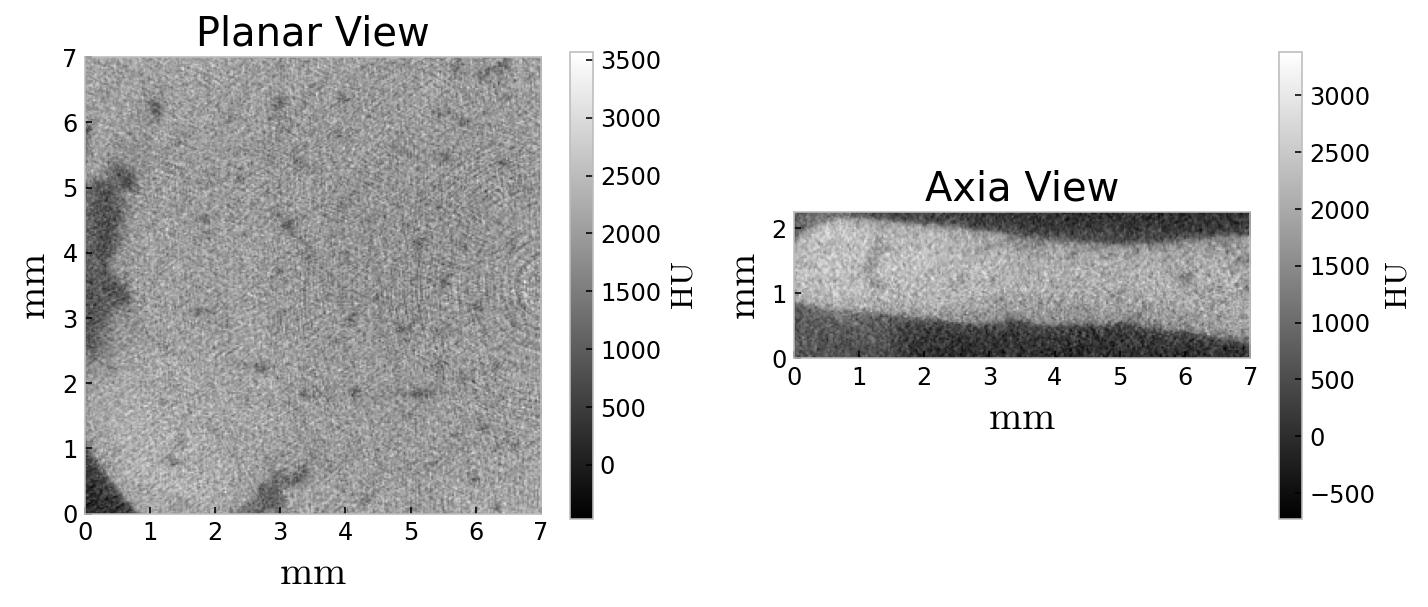

In [117]:
# set the in-plane and in-depth extents 
sample_scan = CT_images[82]
extent_in_plane = [0, 312 * 0.0249, 0, 312 * 0.0249]
extent_in_depth = [0, 312 * 0.0249, 0, sample_scan.shape[0] * 0.0249]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_scan[50, :, :], cmap='gray', extent=extent_in_plane)
plt.title('Planar View', fontsize=20)
plt.grid(False)
cbar = plt.colorbar(shrink=0.7)
cbar.set_label('$\mathrm{HU}$', size=16)
cbar.ax.tick_params(labelsize=12)
plt.xlabel('$\mathrm{mm}$', fontsize=20)
plt.ylabel('$\mathrm{mm}$', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 7)
plt.ylim(0, 7)

plt.subplot(1, 2, 2)
plt.imshow(sample_scan[:, 250, :], cmap='gray', extent=extent_in_depth)
plt.grid(False)
cbar = plt.colorbar(shrink=0.7)
cbar.set_label('$\mathrm{HU}$', size=16)
cbar.ax.tick_params(labelsize=12) 
plt.title('Axia View', fontsize=20)
plt.xlabel('$\mathrm{mm}$', fontsize=20)
plt.ylabel('$\mathrm{mm}$', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 7)
#plt.ylim(0, 7)

plt.tight_layout()
#plt.savefig(fig_path + 'sample_microCT_dense.png', dpi=600)
plt.show()

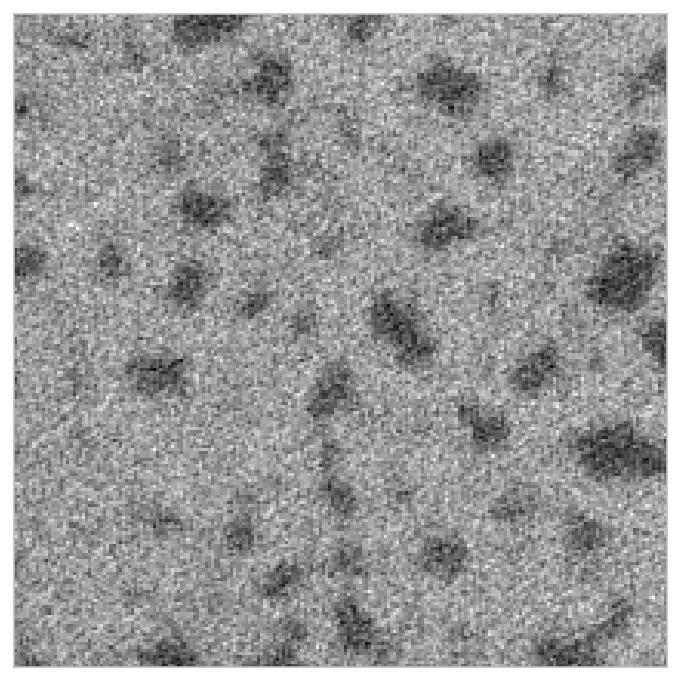

In [118]:
# plot the pore structure of this first sample:
s1_bone = np.copy(CT_images[20])
s1_pore = np.copy(CT_images[20])
# cut a square segment to minimize the size
s1_pore = s1_pore[50:150, 50:-50, 50:-50]

plt.figure(figsize=(6, 6))
plt.imshow(s1_pore[99], cmap='gray')
plt.xticks([])
plt.yticks([])
#plt.savefig(fig_path + 'segmented_skull.png', dpi=400)
plt.show()

we see that the pore structure falls mainly in the 500-1000 HU. Therefore, we will keep these values and set all else to 0. Moreover, we will add a Gaussian filter to smooth out the pores and finally binarize the array for a clean 3D interactive figure. 

In [119]:
# set pore values outside of the 500-1000 range to 0
s1_pore[s1_pore > 1000]=0
s1_pore[s1_pore < 500]=0
# set bone values less than 1000 to 0
s1_bone[s1_bone < 2000]=0
# apply a Gaussian filter with sigma=1
s1_pore = sp.ndimage.gaussian_filter(s1_pore, 0.4)
s1_bone = sp.ndimage.gaussian_filter(s1_bone, 0.4)
# binarize the array by setting all nonzero values to 1
s1_pore[s1_pore !=0] = 1
s1_bone[s1_bone !=0] = 1

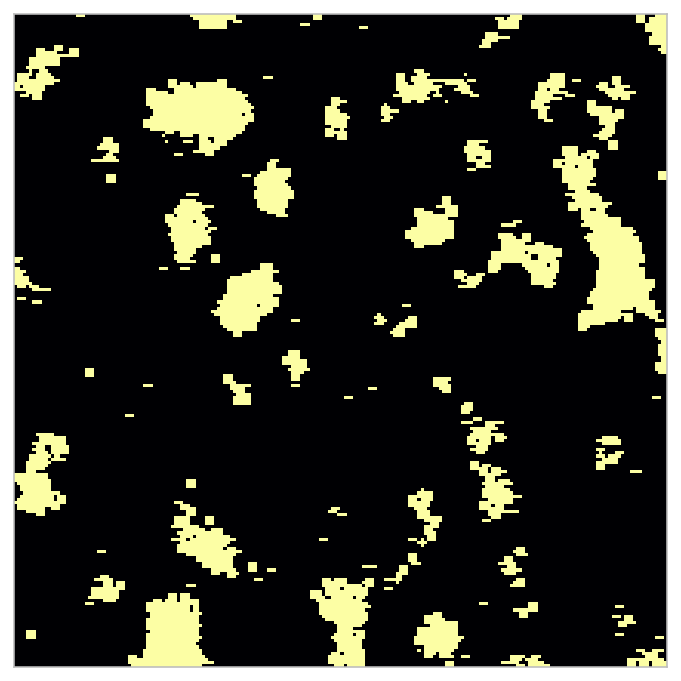

In [120]:
plt.figure(figsize=(6, 6))
plt.imshow(s1_pore[90], cmap='inferno')
plt.xticks([])
plt.yticks([])
#plt.savefig(fig_path + 'segmented_skull_pores.png', dpi=400)
plt.show()

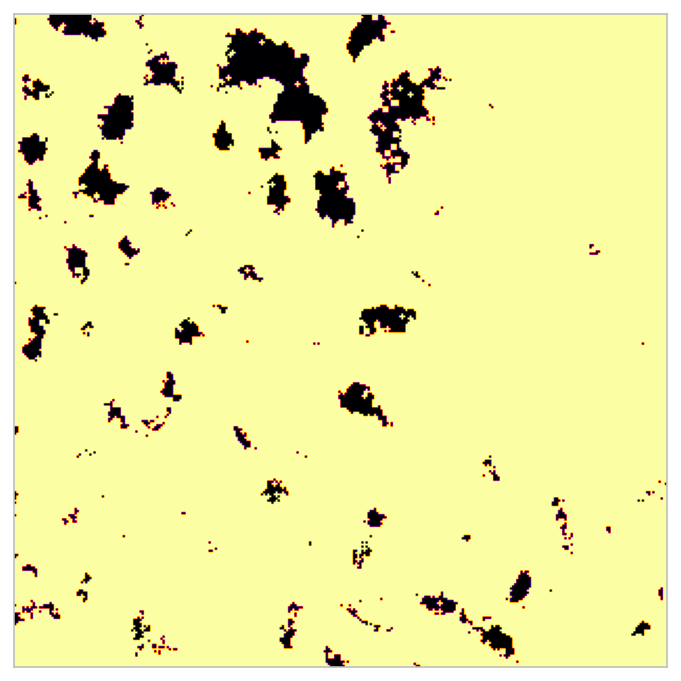

In [121]:
plt.figure(figsize=(6, 6))
plt.imshow(s1_bone[90], cmap='inferno')
plt.xticks([])
plt.yticks([])
#plt.savefig(fig_path + 'segmented_skull_bone.png', dpi=400)
plt.show()

In [122]:
# resample the image to a smaller size for memory purposes
pore_resize_factor = np.array([40, 90, 90]) / s1_pore.shape
bone_resize_factor = np.array([40, 90, 90]) / s1_bone.shape
print(f'pore resize factor: {pore_resize_factor}')
print(f'bone resize factor: {bone_resize_factor}')

pore resize factor: [0.4       0.4245283 0.4245283]
bone resize factor: [0.18604651 0.28846154 0.28846154]


In [123]:
s1_pore_image = sp.ndimage.interpolation.zoom(s1_pore, 
                                              pore_resize_factor, mode='nearest')
s1_bone_image = sp.ndimage.interpolation.zoom(s1_bone, 
                                              bone_resize_factor, mode='nearest')

In [124]:
def plotly_3d(image, mask):
    p = image.transpose(2,1,0)
    step_size = 1
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, 0.99)
    
    x,y,z = zip(*verts) 
    print("Drawing")
        
    # aspect ratios:
    arx = round(image.shape[1] / min(image.shape))
    ary = round(image.shape[2] / min(image.shape))
    arz = round(image.shape[0] / min(image.shape))

    if mask=='bone':
      color='Hot'
    elif mask=='pore':
      color=None
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=color,
                        simplices=faces,
                            showbackground=False,
                            aspectratio=dict(x=arx, y=ary, z=arz),
                            show_colorbar=False,
                        title="Interactive Visualization")
    
    iplot(fig)

In [125]:
plotly_3d(s1_pore_image, mask='pore')

Output hidden; open in https://colab.research.google.com to view.

In [126]:
plotly_3d(s1_bone_image, mask='bone')

Output hidden; open in https://colab.research.google.com to view.

### Halo Removal
*removal of the halo and other noise with HU < 1500*

As we explained in part 2, thre is some halo present potentially due to diffractions about the aluminum aperture. In order to remove those and ensure we have a clean 3D image of the skull fragments alone, we will set all voxels that have HUs less than 1500 to 0. Let's take a look at the before/after scans:

In [127]:
sample_w_halo = np.copy(CT_images[45])

# choose another sample, but this time set HU<1500 to 0
sample_wo_halo = np.copy(sample_w_halo)
sample_wo_halo[sample_wo_halo < 1500] = 0
sample_wo_halo[sample_wo_halo > 3000] = 0

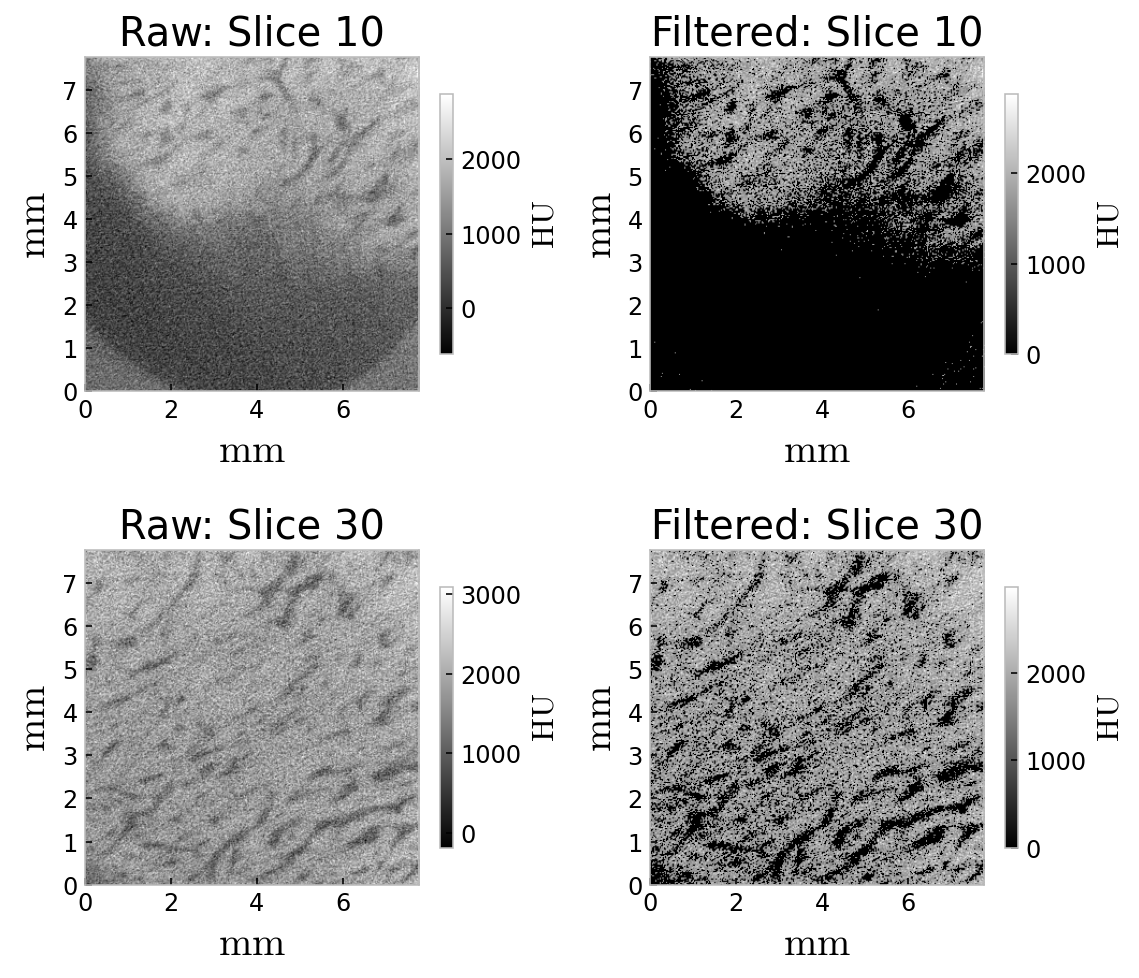

In [129]:
plt.figure(figsize=(8, 7))
plt.subplot(2, 2, 1)
plt.imshow(sample_w_halo[10], cmap='gray', extent=extent_in_plane)
plt.title('Raw: Slice 10', fontsize=20)
plt.grid(False)
cbar = plt.colorbar(shrink=0.7)
cbar.set_label('$\mathrm{HU}$', size=16)
cbar.ax.tick_params(labelsize=12) 
plt.xlabel('$\mathrm{mm}$', fontsize=20)
plt.ylabel('$\mathrm{mm}$', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2, 2, 2)
plt.imshow(sample_wo_halo[10], cmap='gray', extent=extent_in_plane)
plt.grid(False)
cbar = plt.colorbar(shrink=0.7)
cbar.set_label('$\mathrm{HU}$', size=16)
cbar.ax.tick_params(labelsize=12) 
plt.title('Filtered: Slice 10', fontsize=20)
plt.xlabel('$\mathrm{mm}$', fontsize=20)
plt.ylabel('$\mathrm{mm}$', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2, 2, 3)
plt.imshow(sample_w_halo[30], cmap='gray', extent=extent_in_plane)
plt.grid(False)
cbar = plt.colorbar(shrink=0.7)
cbar.set_label('$\mathrm{HU}$', size=16)
cbar.ax.tick_params(labelsize=12) 
plt.title('Raw: Slice 30', fontsize=20)
plt.xlabel('$\mathrm{mm}$', fontsize=20)
plt.ylabel('$\mathrm{mm}$', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2, 2, 4)
plt.imshow(sample_wo_halo[30], cmap='gray', extent=extent_in_plane)
plt.grid(False)
cbar = plt.colorbar(shrink=0.7)
cbar.set_label('$\mathrm{HU}$', size=16)
cbar.ax.tick_params(labelsize=12) 
plt.title('Filtered: Slice 30', fontsize=20)
plt.xlabel('$\mathrm{mm}$', fontsize=20)
plt.ylabel('$\mathrm{mm}$', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
#plt.savefig(fig_path + 'halo_before_after.png', dpi=600)
plt.show()

In [130]:
# # Run this cell only once  
# CT_images_filtered = np.copy(CT_images)
# # apply the halo removal cutoff to the CT images
# for i in range(100):
#   CT_images_filtered[i][CT_images_filtered[i] < 1500] = 0
#   CT_images_filtered[i][CT_images_filtered[i] > 3000] = 0
# np.save('/Volumes/GoogleDrive/My Drive/Pauly Lab/HUnet/SkullData/ \
# CT_images_filtered.npy', CT_images_filtered)

In [131]:
# upload the CT images (input). This should take about 2 min and 30 seconds 
CT_images = np.load('/Volumes/GoogleDrive/My Drive/Pauly Lab/HUnet/SkullData/ \
CT_images_filtered.npy', allow_pickle=True)

In [132]:
# get the mean HU for each fragment. This should take about 30 seconds
CT_mean_HU = [np.mean(CT_images[j]) for j in range(100)]

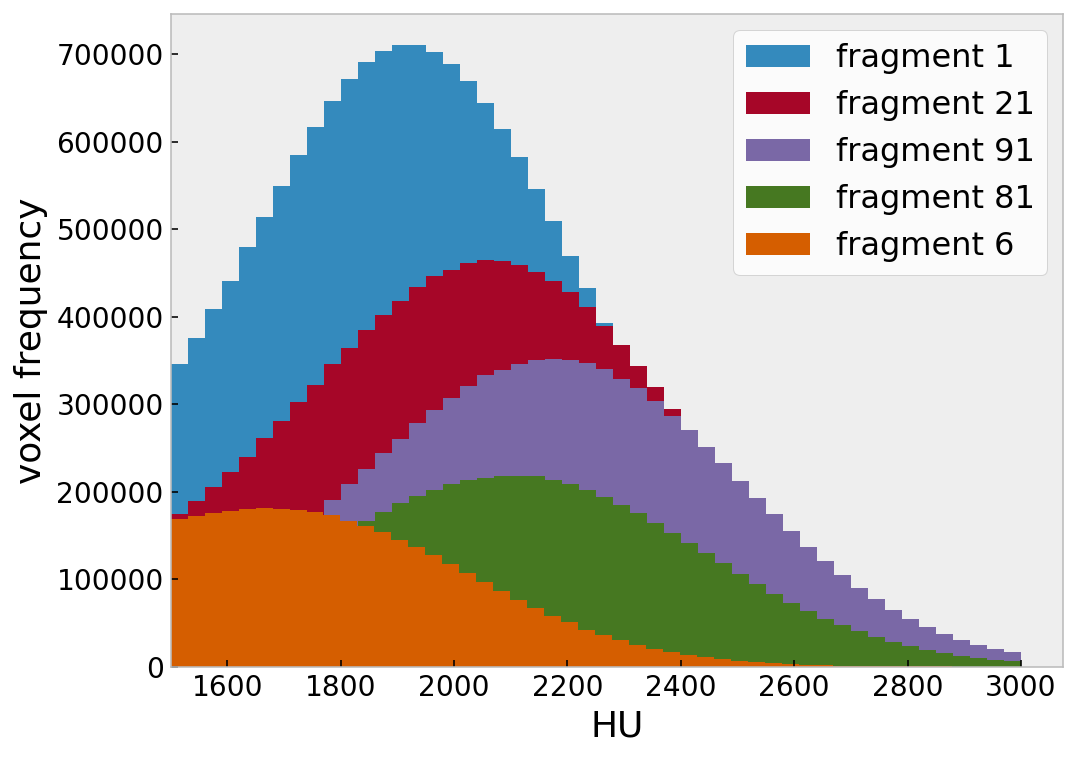

In [159]:
# plot the distribution of HUs for two sample fragments
frag_idx = [0, 20, 90, 80, 5]
plt.figure(figsize=(8, 6))
for i in frag_idx:
  plt.hist(CT_images[i][CT_images[i]!=0].flatten(), 
           bins=50, label='fragment ' + str(i + 1))

plt.grid(False)
plt.legend(facecolor='white', fontsize=16)
plt.xlabel('HU', fontsize=18)
plt.ylabel('voxel frequency', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1500,)
#plt.savefig(fig_path + 'HU_dist', dpi=600)
plt.show()

In [163]:
data_array = np.zeros((100, 2))
data_array[:, 0] = sos_mean
data_array[:, 1] = CT_mean_HU
data_mean = np.mean(data_array, axis=0)

In [164]:
def gaussian(x):
  return 1 / ((2 * np.pi) * (np.linalg.det(data_cov)) ** 0.5) *\
   np.exp(-0.5 * (x - data_mean).T @ np.linalg.inv(data_cov) @ 
          (x - data_mean))

In [165]:
data_cov =1 / 99 * ((data_array - data_mean).T @ (data_array - data_mean))

In [166]:
X, Y = np.meshgrid(np.linspace(1800, 3200, 300), 
                   np.linspace(300, 1900, 300))

pdf = np.zeros((len(X), len(Y)))
for i in range(len(X)):
  for j in range(len(Y)):
    pdf[i][j] = gaussian([X[i,j], Y[i,j]])

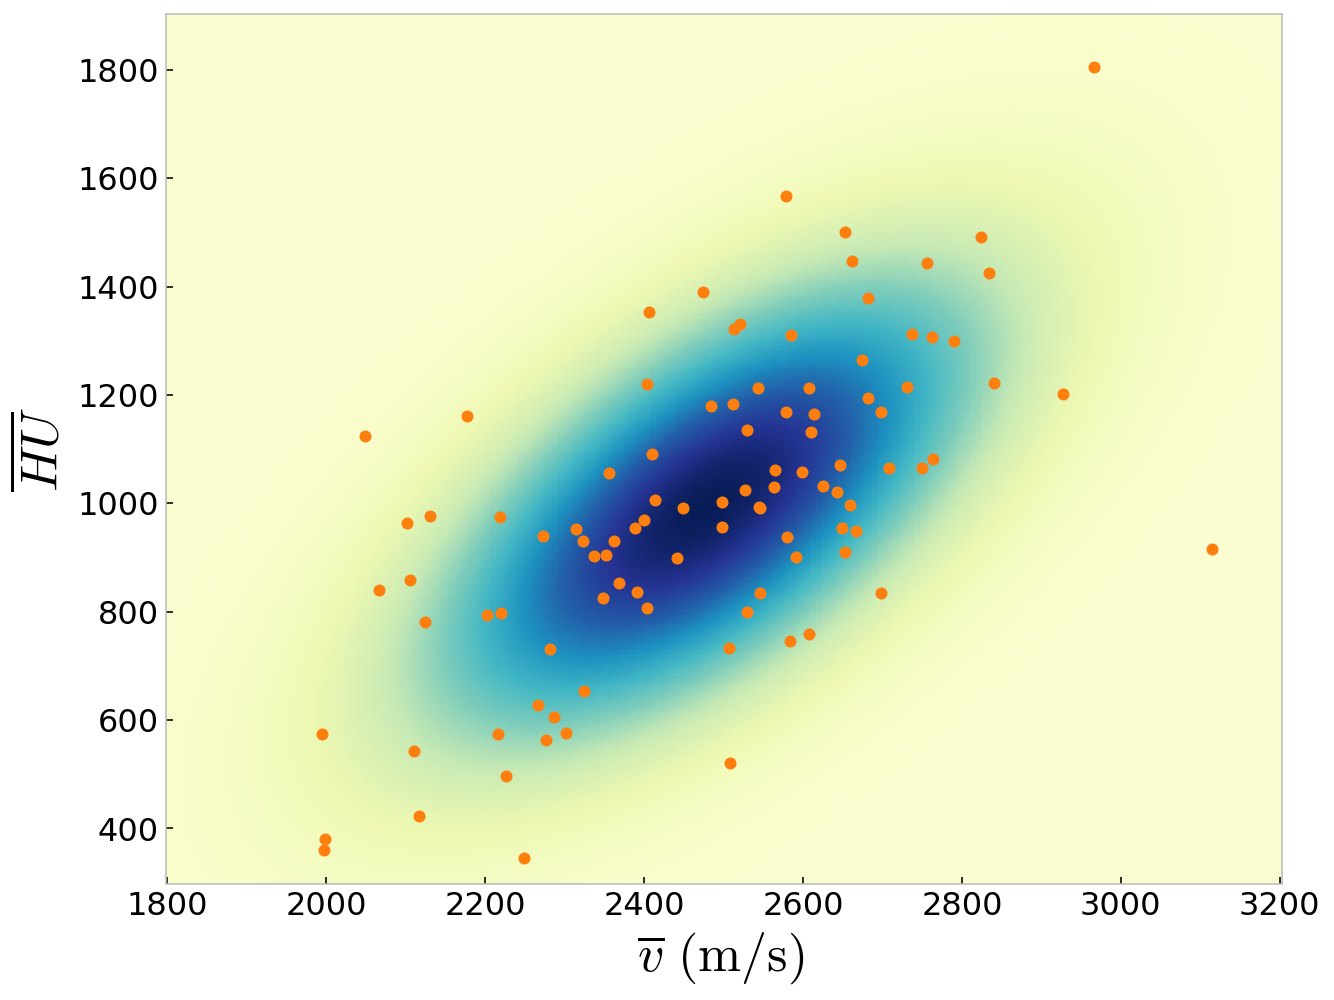

In [191]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(X, Y, pdf, cmap='YlGnBu', vmin=-1e-7, vmax=np.max(pdf), 
               shading='auto')
plt.plot(sos_mean, CT_mean_HU, '.', color='tab:orange', markersize=10)
plt.xlabel('$\overline{v}\  (\mathrm{m/s})$ ', fontsize=26)
plt.ylabel('$\overline{HU}$', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.savefig(fig_path + 'gaussian_fit.png', dpi=600)
plt.show()

In [192]:
Mahal = [np.sqrt((j - data_mean).T @ np.linalg.inv(data_cov) @ (j - data_mean)) for j in data_array]
Mahal_mean = np.mean(Mahal)
Mahal_std = np.std(Mahal)

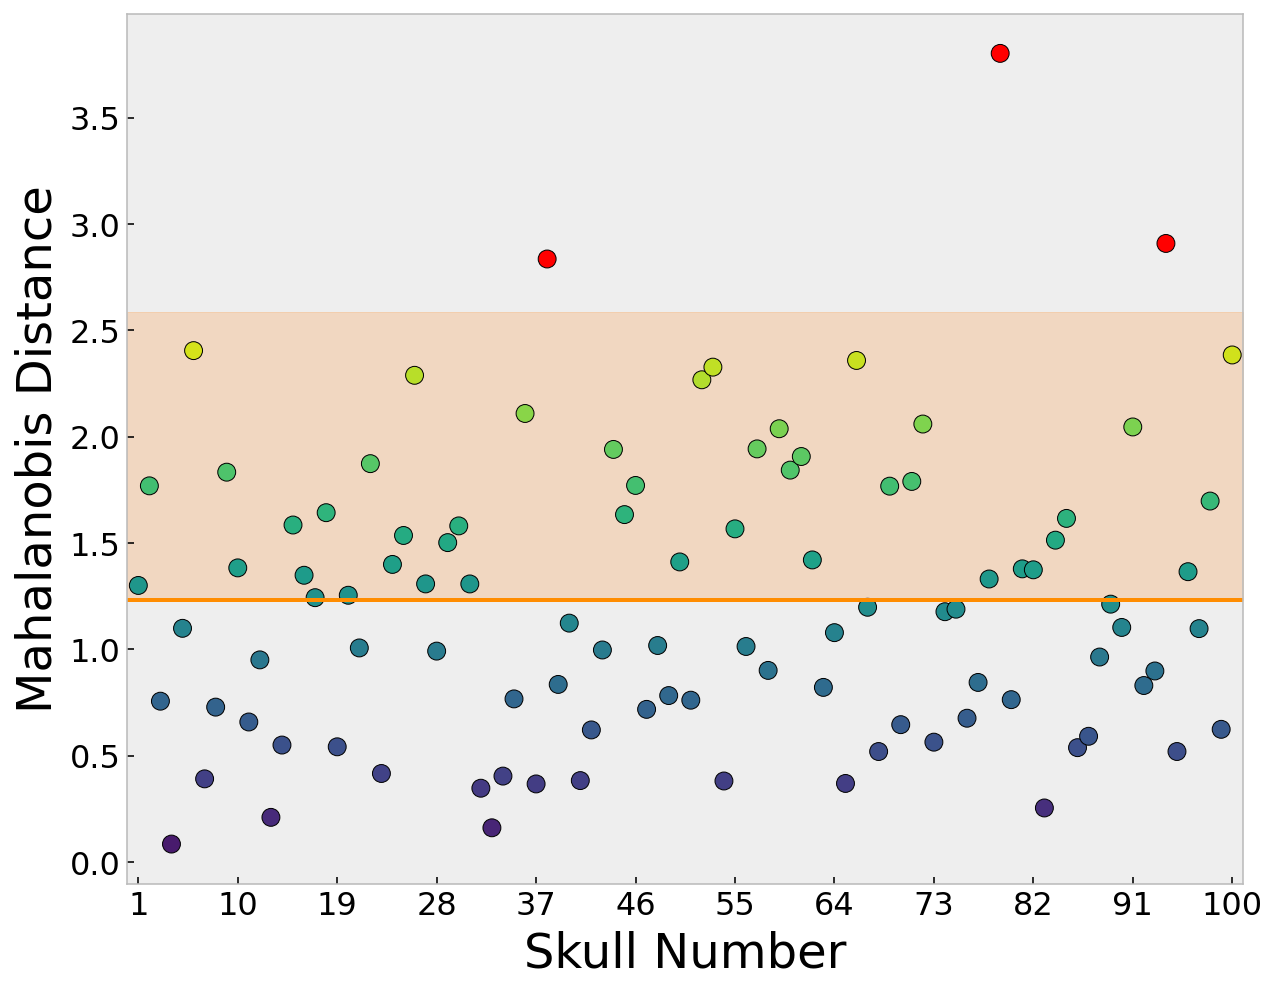

In [211]:
plt.figure(figsize=(10, 8))

x = np.arange(1, 101)
num_colors = 500
cmap = plt.get_cmap('viridis', num_colors)
cmap.set_under('yellow')
cmap.set_over('red')
std2_below = Mahal_mean - 2 * Mahal_std
std2_above = Mahal_mean + 2 * Mahal_std
plt.fill_between(np.arange(0, 102), Mahal_mean, std2_above, 
                 color='tab:orange', alpha=0.2)
plt.axhline(Mahal_mean, color='darkorange')
plt.scatter(np.arange(1, 101), Mahal, c=Mahal, cmap=cmap, vmin=std2_below,
            vmax=std2_above, edgecolors='k', s=80)

plt.xticks(np.arange(1, 101, 9), fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Skull Number', fontsize=24)
plt.ylabel('Mahalanobis Distance', fontsize=24)
plt.xlim(0, 101)
plt.grid(False)
#plt.savefig(fig_path + 'Mahalanobis.png', dpi=600)
plt.show()

In [212]:
indices = [idx for idx, val in enumerate(Mahal) if val > std2_above]

In [213]:
data_array_filtered = data_array[:]
for j in sorted(indices, reverse=True):
  data_array_filtered = np.delete(data_array_filtered, obj=j, axis=0)

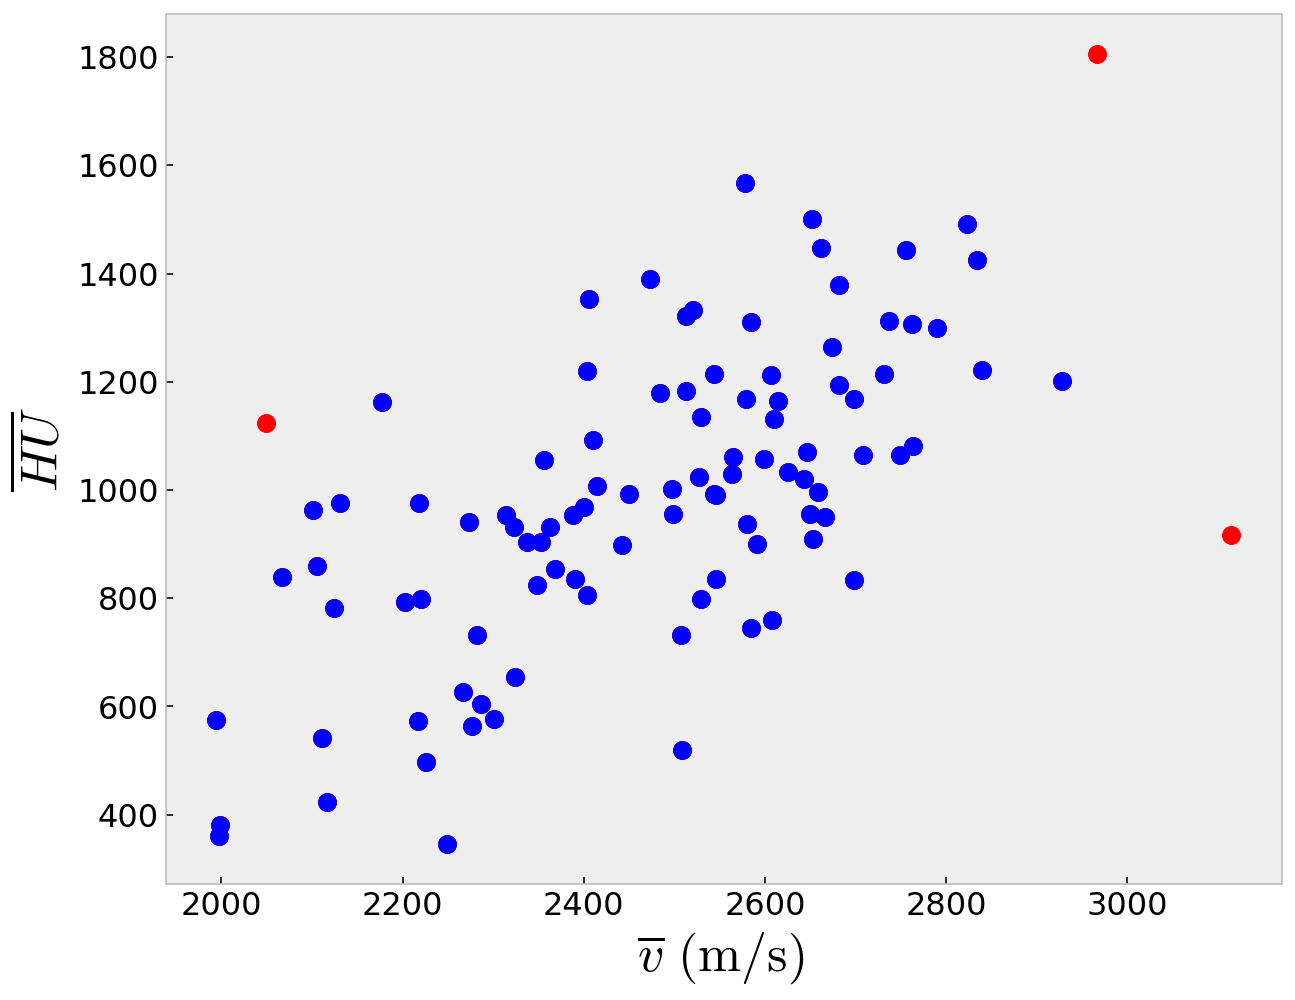

In [217]:
plt.figure(figsize=(10, 8))
plt.scatter(data_array[:,0], data_array[:,1], color='r', s=80)
plt.scatter(data_array_filtered[:,0], data_array_filtered[:,1], color='b', s=80)
plt.xlabel('$\overline{v}\  (\mathrm{m/s})$ ', fontsize=26)
plt.ylabel('$\overline{HU}$', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
#plt.savefig(fig_path + 'Mahalanobis-outlier.png', dpi=600)
plt.show()

### Normalize the Data 
Normalize the input according to the following equation:

\begin{equation}
CT_{norm} = \frac{CT - CT_{min}}{CT_{max} - CT_{min}}
\end{equation}

Similarly, normalize the output (labels):

\begin{equation}
sos_{norm} = \frac{sos - sos_{min}}{sos_{max} - sos_{min}}
\end{equation}


For the CT images, use $HU_{max}=3000$ and $HU_{min}=0$.

In [218]:
def normalize(array, array_max, array_min):
    ''' function to normalize the data. minimum and maximum
    values are already known and hardcoded to be 0 and 3000, respectively.

    Input params
    ------------
    volume: input 3d CT array

    Output
    ------
    normalized 3d array
    '''
    array_norm = (array - array_min) / (array_max - array_min)
    
    return array_norm

obviously we also need a reversal of the normalization for the speed of sound so that we can convert the neural net output to actual acoustic velocity:

In [219]:
def rev_normalize(array_norm, array_max, array_min):
    array = array_norm * (array_max - array_min) + array_min
    
    return array

In [220]:
# get the max and min mean velocities 
sos_max = max(sos_mean)
sos_min = min(sos_mean)

In [221]:
# # normalize the data for the deep neural network 
# CT_norm = normalize(CT_images, 3000, 0)
# sos_norm = normalize(sos_mean, sos_max, sos_min)

In [222]:
# # run this cell only once to save the normalized input/output values 
# np.save('/Volumes/GoogleDrive/My Drive/Pauly Lab/HUnet/SkullData/ \
# CT_norm.npy', CT_norm)

# np.save('/Volumes/GoogleDrive/My Drive/Pauly Lab/HUnet/SkullData/ \
# sos_norm.npy', sos_norm)

In [223]:
sos_norm = np.load('/Volumes/GoogleDrive/My Drive/Pauly Lab/HUnet/SkullData/\
sos_norm.npy', allow_pickle=True)

CT_norm = np.load('/Volumes/GoogleDrive/My Drive/Pauly Lab/HUnet/SkullData/\
CT_norm.npy', allow_pickle=True)

In [224]:
# remove the outliers:
for j in sorted(indices, reverse=True):
  sos_norm = np.delete(sos_norm, j)
  CT_norm = np.delete(CT_norm, j)
  

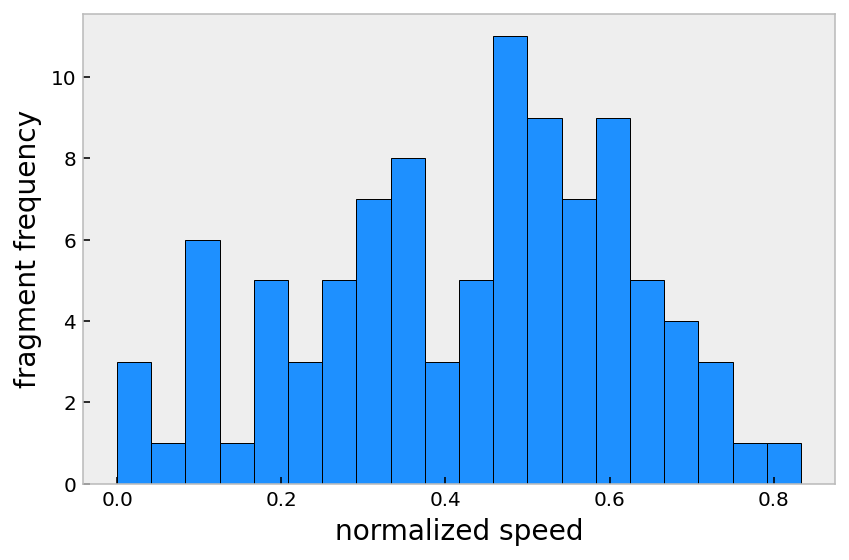

In [240]:
plt.hist(sos_norm, bins=20, edgecolor='k', color='dodgerblue')
plt.grid(False)
plt.xlabel('normalized speed', fontsize=14)
plt.ylabel('fragment frequency', fontsize=14)

plt.tight_layout()
#plt.savefig(fig_path + 'norm_sos_histogram.png', dpi=600)
plt.show()

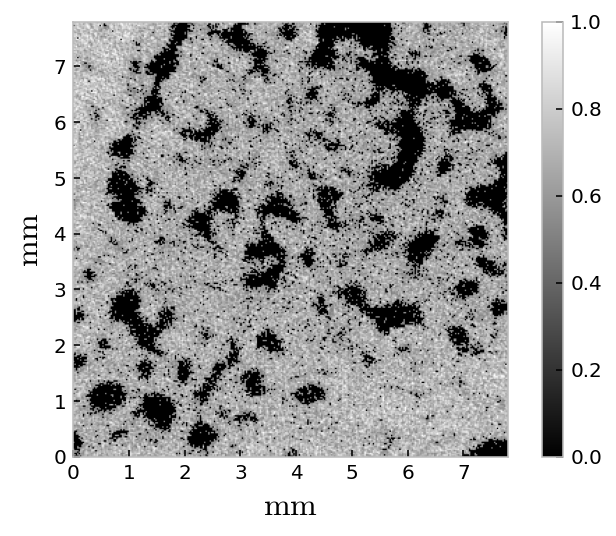

In [241]:
plt.imshow(CT_norm[0][40], extent=(0, 312 * 0.025, 0, 312 * 0.025), 
           cmap='gray')
plt.colorbar()
plt.xlabel('$\mathrm{mm}$', fontsize=16)
plt.ylabel('$\mathrm{mm}$', fontsize=16)
plt.xticks(np.arange(0, 8, 1))
plt.yticks(np.arange(0, 8, 1))
plt.grid(False)
#plt.savefig(fig_path + 'normalized_CT_sample', dpi=600)
plt.show()

In [242]:
# import random
# np.random.seed(999)
# # generate 10 random digits to choose the test set 
# test_idx = random.sample(range(100), 10)

# # generate the test set of length 10 fragments 
# test_input = CT_norm[test_idx]
# test_label = sos_norm[test_idx]

# # generate the train/validation of length 90 fragments 
# train_idx = np.delete(np.array(np.arange(0, 100)), test_idx)
# train_input = CT_norm[train_idx]
# train_label = sos_norm[train_idx]

In [243]:
train_idx = np.arange(0, 97)
train_input = CT_norm[train_idx]
train_label = sos_norm[train_idx]

In [244]:
# do a 75/15 split 
for i in range(5):
  if i < 4:
    idx = np.arange((i * 20), (i + 1) * 20)
    globals()['train_x_fold' + str(i+1)] = np.delete(train_input, idx)
    globals()['train_y_fold' + str(i+1)] = np.delete(train_label, idx)
    globals()['val_x_fold' + str(i+1)] = train_input[idx]
    globals()['val_y_fold' + str(i+1)] = train_label[idx]
  if i == 4:
    idx = np.arange(80, 97)    
    globals()['train_x_fold' + str(i+1)] = np.delete(train_input, idx)
    globals()['train_y_fold' + str(i+1)] = np.delete(train_label, idx)
    globals()['val_x_fold' + str(i+1)] = train_input[idx]
    globals()['val_y_fold' + str(i+1)] = train_label[idx]

In [251]:
print(f'training set size for folds 1-4: {len(train_x_fold4)}')
print(f'validation set size for folds 1-4: {len(val_x_fold4)}')
print()
print(f'training set size for fold 5: {len(train_x_fold5)}')
print(f'validation set size for fold 5: {len(val_x_fold5)}')

training set size for folds 1-4: 77
validation set size for folds 1-4: 20

training set size for fold 5: 80
validation set size for fold 5: 17


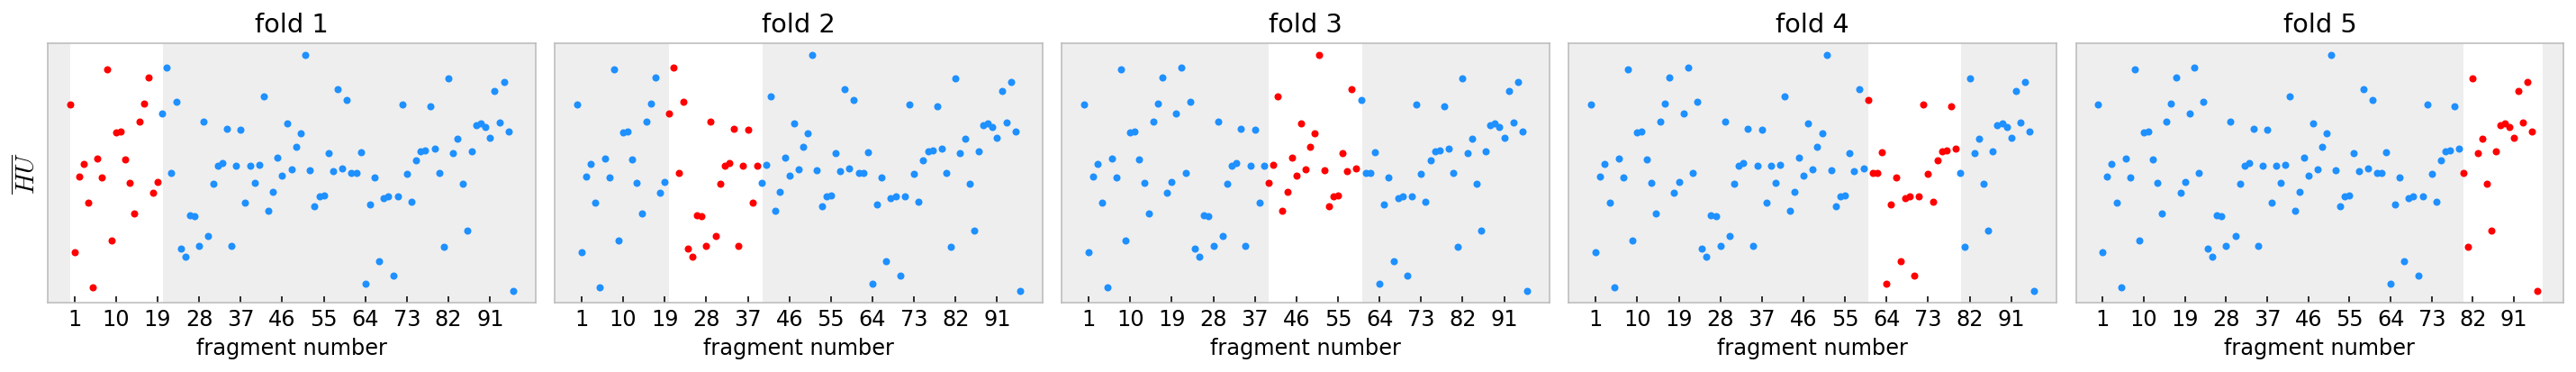

In [265]:
plot_data_train = [train_x_fold1, train_x_fold2, train_x_fold3, 
              train_x_fold4, train_x_fold5]
plot_data_val = [val_x_fold1, val_x_fold2, val_x_fold3, 
val_x_fold4, val_x_fold5]
plt.figure(figsize=(20, 3))
for i in range(0, 5):
  plt.subplot(1, 5, i+1)
  if i < 4:
    plt.title('fold ' + str(i+1))
    plt.plot(np.concatenate((np.arange((i * 20)), np.arange((i+1) * 20, 97))), 
             [np.mean(plot_data_train[i][j]) for j in range(77)], '.', 
             color='dodgerblue')
    plt.plot(np.arange(i * 20, (i+1)*20), 
             [np.mean(plot_data_val[i][j]) for j in range(20)], '.', 
             color='red')
    plt.axvspan(i * 20, (i+1)*20, color='white')
    plt.yticks([])
    plt.xticks(np.arange(1, 97, 9), fontsize=12)
    plt.xlabel('fragment number', fontsize=12)
    plt.grid(False)
  if i == 0:
    plt.ylabel('$\overline{HU}$', fontsize=14)

  if i == 4:
    plt.title('fold ' + str(i+1))
    plt.plot(np.arange(80), [np.mean(plot_data_train[i][j]) \
                             for j in range(80)], '.', color='dodgerblue')
    plt.plot(np.arange(80, 97), [np.mean(plot_data_val[i][j]) for\
                                 j in range(17)], '.', color='red')
    plt.axvspan(80, 97, color='white')
    plt.xticks(np.arange(1, 97, 9), fontsize=12)
    plt.yticks([])
    plt.xlabel('fragment number', fontsize=12)
    plt.grid(False)

plt.tight_layout()
#plt.savefig(fig_path + 'fold_visualization.png', dpi=600)
plt.show()

# Dataset Format

At this point the dataset is ready to be used in our neural network. The input is the ```CT_images_filtered``` array that contains the preprocessed and filtered skull CT fragments. The output or the labels are the mean acoustic velocities saved in the ```sos_mean``` file. 


Typically, CT scans of the lung are $1000\times 512\times 512$. Our dataset, after resizing, is $Z\times 312\times 312$.